# **Filo-Transformer (COM FILOGENIA)**


In [ ]:
# ----------------------------------------
# SETUP 1: Instalação de Bibliotecas
# ----------------------------------------
!pip install openai transformers[sentencepiece] networkx scikit-learn pandas tensorflow node2vec matplotlib

In [2]:
# ----------------------------------------
# SETUP 2: Imports de bibliotecas
# ----------------------------------------
import os
import gc
import warnings
import time
import getpass # Para a opção de inserção manual da chave, se preferir

import openai
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import networkx as nx
from networkx.algorithms import community
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import recall_score, f1_score
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    GlobalAveragePooling1D,
    Concatenate,
    Dense,
    Dropout,
    LayerNormalization,
    Normalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel
import matplotlib.pyplot as plt # Remova se não for usar

from google.colab import userdata # Para segredos do Colab
from google.colab import drive # Se for usar Google Drive para datasets

warnings.filterwarnings('ignore', '.*set_learning_phase.*', category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='node2vec')

In [3]:
# ------------------------------------------------------------
# SETUP - VARIÁVEIS GLOBAIS COMPARTILHADAS ENTRE MODELOS
# ------------------------------------------------------------
GPT_MODEL_EMBEDDINGS  = "text-embedding-3-large"   # text-embedding-3-large   ou text-embedding-3-small
DATASET_FILE_NAME     = 'pheme_all.csv'            # Substitua pelo nome do seu arquivo CSV carregado
SIMILARITY_VALUE = 0.75                            # Grau se similaridade que faz um nó ter arresta com outro. Quanto + similary menor numero de arestas.


In [4]:
# ------------------------------------------------------------
# Recupera OPENAI_API_KEY / ou seleciona SBERT automaticamente
# ------------------------------------------------------------
try:
    openai.api_key = userdata.get('OPENAI_API_KEY')
    if not openai.api_key:
        raise ValueError("Chave não encontrada nos segredos.")
    EmbeddingsModel = "GPT"
    print("Chave da API OpenAI encontrada. Usando GPT para embeddings.")
except:
    print("Chave da API OpenAI não encontrada ou erro ao buscar. Alternando para SBERT.")
    EmbeddingsModel = "SBERT"
    openai.api_key = None # Garante que está None se não for usar GPT

# ----------------------------------------
# Configuração de GPU (função original check_gpu() pode ser mantida aqui)
# ----------------------------------------
def check_gpu() -> None:
    print(f"TensorFlow version: {tf.__version__}")
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        print("No GPU detected. Using CPU.")
        return
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth enabled on {gpu}.")
        except RuntimeError:
            pass
    print(f"GPUs: {gpus}\n")

check_gpu() # Chamar a função para verificar e configurar a GPU

# --------------------------------------------------------------------------------
# OpenAI GPT Embeddings (Ajuste na verificação da API Key se necessário)
# --------------------------------------------------------------------------------
def encode_gpt(texts: list[str], batch_size: int = 100, model: str = "text-embedding-3-small") -> np.ndarray:
    if not openai.api_key: # Checagem adicional caso EmbeddingsModel seja GPT mas a chave falhou de alguma forma
        raise RuntimeError("OPENAI_API_KEY não definido e EmbeddingsModel é GPT.")
    print("Calculando embeddings GPT via API...")
    # ... (resto da função original encode_gpt)
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        response = openai.embeddings.create(model=model, input=batch)
        batch_emb = [datum.embedding for datum in response.data]
        embeddings.append(np.array(batch_emb, dtype=np.float32))
        time.sleep(1) # Respeitar rate limits
    return np.vstack(embeddings)

# --------------------------------------------------------------------------------
# SBERT: codificação de textos (função original encode_sbert() pode ser mantida aqui)
# --------------------------------------------------------------------------------
auto_tokenizer = AutoTokenizer.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2"
)
sbert_model = TFAutoModel.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2", from_pt=True
)
sbert_model.trainable = False

def encode_sbert(texts: list[str], batch_size: int = 64) -> np.ndarray:
    print("Calculando embeddings SBERT...")
    # ... (resto da função original encode_sbert)
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        enc = auto_tokenizer(
            batch, padding=True, truncation=True,
            return_tensors='tf', max_length=512
        )
        out = sbert_model(enc)
        mask = tf.cast(enc['attention_mask'][..., None], tf.float32)
        summed = tf.reduce_sum(out.last_hidden_state * mask, axis=1)
        counts = tf.reduce_sum(mask, axis=1)
        embeddings.append((summed / counts).numpy())
    return np.vstack(embeddings)

# --------------------------------------------------------------------------------
# Pré-processamento numérico
# --------------------------------------------------------------------------------
class Preprocessor:
    def __init__(self) -> None:
        self.normalizer = Normalization()

    def fit(self, X: np.ndarray) -> None:
        if X.size:
            self.normalizer.adapt(X)

    def transform(self, X: np.ndarray) -> np.ndarray:
        return self.normalizer(X).numpy() if X.size else X

# --------------------------------------------------------------------------------
# Atributos TAG filogenéticos
# --------------------------------------------------------------------------------
def gini_coefficient(values: np.ndarray) -> float:
    arr = np.sort(values.astype(float))
    n = arr.size
    if n == 0 or np.allclose(arr, 0):
        return 0.0
    cum = np.cumsum(arr)
    if cum[-1] == 0:
        return 0.0
    idx = np.arange(1, n + 1)
    return (2 * np.sum(idx * arr)) / (n * cum[-1]) - (n + 1) / n


def attrs_tag_extended(
    G: nx.DiGraph,
    nodes: list[int],
    sim_matrix: np.ndarray,
    nodes_in_sim: list[int] = None
    ) -> pd.DataFrame:
    cols_base = [
        'pagerank','deg_norm','deg_in','deg_out',
        'n_anc','n_desc','gini_sim','num_comms',
        'depth_norm','is_leaf','recomb_degree',
        'entropy_anc','mut_rate','subtree_size',
        'closeness','betweenness'
    ]
    cols_emb = [f'graph_emb_{i}' for i in range(64)]
    all_cols = cols_base + cols_emb
    if isinstance(nodes, (np.ndarray, list)) and len(nodes) == 0:
        return pd.DataFrame(columns=all_cols, index=nodes).astype(float)
    if nodes_in_sim is None:
        nodes_in_sim = nodes
    map_sim = {nid: idx for idx, nid in enumerate(nodes_in_sim) if nid in nodes}
    df = pd.DataFrame(index=nodes)
    pr = nx.pagerank(G, weight='weight') if G.number_of_nodes() else {}
    df['pagerank'] = df.index.map(lambda n: pr.get(n, 0.0))
    max_deg = max(dict(G.degree()).values()) if G.number_of_nodes() else 1
    df['deg_norm'] = df.index.map(lambda n: G.degree(n)/max_deg if max_deg > 0 else 0.0) # Adicionado if max_deg > 0
    df['deg_in'] = df.index.map(lambda n: G.in_degree(n))
    df['deg_out'] = df.index.map(lambda n: G.out_degree(n))
    anc = {n: len(list(nx.ancestors(G, n))) for n in nodes}
    df['n_anc'] = pd.Series(anc)
    df['n_desc'] = df.index.map(lambda n: len(list(nx.descendants(G, n))))
    for n in nodes:
        if n not in map_sim: continue # Adicionado para segurança
        valid_neighbors = [v for v in G.neighbors(n) if v in map_sim]
        valid_indices = [map_sim[v] for v in valid_neighbors]
        df.at[n,'gini_sim'] = gini_coefficient(np.sort(sim_matrix[map_sim[n], valid_indices])) if valid_indices else 0.0

    # Comunidades
    if G.number_of_nodes() > 0 and G.number_of_edges() > 0 : # Adicionado checagem
        und = G.to_undirected()
        comms = community.greedy_modularity_communities(und) if und.nodes else []
        cmap = {nd: i for i, comm_set in enumerate(comms) for nd in comm_set} # Corrigido nome da variável
        df['num_comms'] = df.index.map(lambda n: len({cmap.get(n, -1)})) # -1 para nós não mapeados
    else:
        df['num_comms'] = 0.0

    # Profundidade
    roots = [n for n, d in G.in_degree() if d == 0]
    depth = {}
    if G.number_of_nodes() > 0: # Adicionado checagem
        for r in roots:
            for n_node, dist in nx.single_source_shortest_path_length(G, r).items(): # n_node para evitar conflito
                depth[n_node] = min(depth.get(n_node, np.inf), dist)
    if depth:
        maxd = max(depth.values()) if depth else 0 # Adicionado if depth
        if maxd == 0:
            df['depth_norm'] = 0.0
        else:
            df['depth_norm'] = df.index.map(lambda n_node: depth.get(n_node, 0)/maxd)
    else:
        df['depth_norm'] = 0.0

    df['is_leaf'] = df.index.map(lambda n: G.out_degree(n) == 0 if G.has_node(n) else True) # Adicionado if G.has_node(n)
    df['recomb_degree'] = df.index.map(lambda n: max(0, G.in_degree(n)-1) if G.has_node(n) else 0) # Adicionado if G.has_node(n)

    ent = {}
    for n_node in nodes: # n_node para evitar conflito
        if n_node not in map_sim or not G.has_node(n_node): continue # Adicionado para segurança
        preds = [p for p in G.predecessors(n_node) if p in map_sim]
        if preds:
            w = np.array([sim_matrix[map_sim[n_node], map_sim[p]] for p in preds])
            p_norm = w / w.sum() if w.sum() > 0 else np.zeros_like(w) # Evita divisão por zero
            ent[n_node] = -np.sum(p_norm * np.log(p_norm + 1e-12)) # Adicionado 1e-12 para estabilidade
        else:
            ent[n_node] = 0.0
    df['entropy_anc'] = pd.Series(ent)

    df['mut_rate'] = df.index.map(
        lambda n_node: 1 - np.mean([ # n_node para evitar conflito
            sim_matrix[map_sim[n_node], map_sim[p]]
            for p in G.predecessors(n_node) if p in map_sim and G.has_node(n_node) # Adicionado G.has_node
        ]) if G.has_node(n_node) and G.in_degree(n_node) > 0 and any(p in map_sim for p in G.predecessors(n_node)) else 0.0
    ) # Adicionado G.has_node e checagem de predecessores em map_sim
    df['subtree_size'] = df.index.map(lambda n_node: len(nx.descendants(G, n_node)) + 1 if G.has_node(n_node) else 1) # n_node e G.has_node

    # Centralidades
    if G.number_of_nodes() > 0: # Adicionado checagem
        df['closeness'] = pd.Series(nx.closeness_centrality(G))
        df['betweenness'] = pd.Series(nx.betweenness_centrality(G))
    else:
        df['closeness'] = 0.0
        df['betweenness'] = 0.0

    emb = np.zeros((len(nodes), 64))
    try:
        from node2vec import Node2Vec
        # Garante que G tenha nós antes de tentar criar o modelo Node2Vec
        if G.number_of_nodes() > 1 and G.number_of_edges() > 0: # Adicionado > 1 e checagem de arestas
            # Certifique-se que todos os nós em 'nodes' existem em G para Node2Vec
            valid_nodes_for_n2v = [str(n) for n in nodes if G.has_node(n)]
            if len(valid_nodes_for_n2v) > 1:
                sub_G = G.subgraph(valid_nodes_for_n2v).copy() # Use .copy() para evitar warnings
                if sub_G.number_of_nodes() > 1 and sub_G.number_of_edges() > 0:
                    n2v = Node2Vec(sub_G, dimensions=64, walk_length=10, num_walks=50, workers=1, quiet=True)
                    model_n2v = n2v.fit(window=5, min_count=1)
                    # Mapear de volta para os índices originais em 'emb'
                    node_to_idx = {node_id: i for i, node_id in enumerate(nodes)}
                    for node_str in model_n2v.wv.index_to_key:
                        original_node_id = int(node_str)
                        if original_node_id in node_to_idx:
                             emb[node_to_idx[original_node_id], :] = model_n2v.wv[node_str]
    except ImportError:
        print("Node2Vec não instalado. Pulando embeddings de grafo.")
        pass
    except Exception as e:
        print(f"Erro ao calcular embeddings de grafo com Node2Vec: {e}")
        pass

    for i in range(64):
        df[f'graph_emb_{i}'] = emb[:, i] if len(nodes) > 0 else 0.0 # Adicionado if
    df = df.reindex(columns=all_cols, fill_value=0.0)
    return df.astype(float)

# --------------------------------------------------------------------------------
# FT-Transformer
# --------------------------------------------------------------------------------
def ft_block(x: tf.Tensor, dim: int, heads: int, ff_dim: int, rate: float) -> tf.Tensor:
    att = tf.keras.layers.MultiHeadAttention(num_heads=heads, key_dim=dim//heads, dropout=rate)(x, x) # num_heads, key_dim
    x1 = LayerNormalization(epsilon=1e-6)(x + att)
    ff = Dense(ff_dim, activation='gelu')(x1)
    ff = Dropout(rate)(ff)
    ff = Dense(dim)(ff)
    return LayerNormalization(epsilon=1e-6)(x1 + ff)

def build_dual_ft(
    d_model: int,
    d_tag: int,
    n_blocks: int = 2,
    dropout_rate: float = 0.2,
    learning_rate: float = 5e-5,
    heads: int = 8
) -> Model:
    """Constrói modelo Dual-Input FT-Transformer."""
    txt_in = Input(shape=(1, d_model), name='txt_in') # Adicionado shape=
    inputs = [txt_in]
    x = txt_in # Esta linha pode não ser ideal se d_tag=0, x será sobrescrito ou não concatenado

    current_representation = txt_in

    if d_tag > 0: # Modificado para > 0
        tag_in = Input(shape=(1, d_tag), name='tag_in') # Adicionado shape=
        # O nome 'proj' é usado, mas a camada não é explicitamente nomeada 'proj'
        # O nome da camada de projeção não é crítico a menos que você precise referenciá-la.
        projected_tag = Dense(d_model, activation='relu', name='tag_projection')(tag_in)
        current_representation = Concatenate(axis=1)([txt_in, projected_tag])
        inputs.append(tag_in)

    x = current_representation # x é agora a entrada para os blocos FT.

    for _ in range(n_blocks):
        # `d_model` aqui refere-se à dimensão de cada "token" (embedding de texto ou TAG projetado)
        x = ft_block(x, d_model, heads, 2*d_model, dropout_rate)

    x = GlobalAveragePooling1D(data_format='channels_last')(x) # data_format pode ser útil
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs=inputs, outputs=out) # Adicionado inputs=, outputs=
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), # Adicionado learning_rate=
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

# --------------------------------------------------------------------------------
# Função Principal (PIPELINE)
# --------------------------------------------------------------------------------
def main_filo(dataset_path: str) -> dict: # Removido default para dataset_path
    # Carrega dados
    print(f"Carregando dados de: {dataset_path}")
    df = pd.read_csv(dataset_path)

    # ... (resto da função main original)
    texts = df['text'].astype(str).tolist()
    labels = df['label'].to_numpy()

    # Embeddings
    if EmbeddingsModel == "GPT":
        X_emb = encode_gpt(texts)
    else: # SBERT
        X_emb = encode_sbert(texts)

    X_emb = X_emb / (np.linalg.norm(X_emb, axis=1, keepdims=True) + 1e-9)
    print("Embeddings concluídos.")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4321)
    accs, aucs, recs, f1s = [], [], [], []
    all_y_true_filo = []
    all_y_pred_proba_filo = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_emb, labels), start=1):
        print(f"\nFold {fold}/{skf.n_splits}")
        gc.collect(); tf.keras.backend.clear_session()

        # train_idx e test_idx são os índices ORIGINAIS do dataset completo (df)
        # para este fold específico.

        X_tr_fold_emb = X_emb[train_idx] # Embeddings dos textos de treino deste fold
        X_te_fold_emb = X_emb[test_idx]   # Embeddings dos textos de teste deste fold
        y_tr_fold = labels[train_idx]
        y_te_fold = labels[test_idx]

        # 1. Combinar dados de treino e teste DESTE FOLD para construir o grafo
        X_fold_data_combined = np.vstack((X_tr_fold_emb, X_te_fold_emb))

        # Mapear índices locais (0 a N_fold-1) para os índices ORIGINAIS do dataset
        # Estes são os IDs que os nós no grafo G_fold terão.
        original_indices_in_current_fold = np.concatenate((train_idx, test_idx))

        # 2. Construir o grafo G_fold com todos os nós do fold atual
        G_fold = nx.DiGraph()
        G_fold.add_nodes_from(original_indices_in_current_fold) # Nós são os IDs originais

        # Calcular matriz de similaridade para TODOS os dados do fold atual
        sim_matrix_current_fold = X_fold_data_combined.dot(X_fold_data_combined.T)
        np.fill_diagonal(sim_matrix_current_fold, 0) # Auto-similaridade não é útil

        if len(X_fold_data_combined) > 1:
            k_for_fold = min(5, len(X_fold_data_combined) - 1) # k para o KNN

            # kneighbors_graph opera em índices locais (0 a N_fold_combined-1)
            # de X_fold_data_combined
            knn_adj_matrix_fold = kneighbors_graph(
                X_fold_data_combined,
                k_for_fold,
                mode='connectivity',
                metric='cosine',
                include_self=False
            ).tocoo()

            edges_for_G_fold = []
            for i, j in zip(knn_adj_matrix_fold.row, knn_adj_matrix_fold.col):
                # i, j são índices LOCAIS em X_fold_data_combined
                # sim_matrix_current_fold[i, j] é a similaridade.

                # Converter i, j (locais no fold combinado) para os IDs ORIGINAIS
                original_node_id_i = original_indices_in_current_fold[i]
                original_node_id_j = original_indices_in_current_fold[j]

                similarity_score = sim_matrix_current_fold[i, j]
                if similarity_score >= SIMILARITY_VALUE: # Seu limiar de similaridade
                     edges_for_G_fold.append((original_node_id_i, original_node_id_j, {'weight': similarity_score}))
            G_fold.add_edges_from(edges_for_G_fold)

        # Visualização do grafo (opcional, pode ser mantido para o primeiro fold)
        if fold == 1:
          global G_captured_for_visualization_global
          global G_labels_for_visualization_global
          G_captured_for_visualization_global = G_fold.copy()
          node_ids_in_graph_vis = list(G_captured_for_visualization_global.nodes())
          # labels_of_nodes_in_graph_vis precisa ser mapeado corretamente
          # Se original_indices_in_current_fold são os nós, e labels são os labels do dataset total:
          labels_map_for_vis = {original_id: label for original_id, label in zip(np.arange(len(labels)), labels)}
          G_labels_for_visualization_global = {node_id: labels_map_for_vis.get(node_id) for node_id in node_ids_in_graph_vis}
          print(f"Grafo do Fold 1 (transdutivo) capturado com {G_captured_for_visualization_global.number_of_nodes()} nós.")


        df_tag_all_nodes_in_fold = attrs_tag_extended(
            G_fold,
            list(original_indices_in_current_fold), # Nós para os quais calcular TAGs (IDs originais)
            sim_matrix_current_fold,                 # Matriz de similaridade (indexada localmente 0..N-1)
            nodes_in_sim=list(original_indices_in_current_fold) # Mapeia IDs originais para índices da sim_matrix
        )
        # O df_tag_all_nodes_in_fold terá os original_indices_in_current_fold como índice.

        # 4. Obter T_tr e T_te a partir de df_tag_all_nodes_in_fold
        # Os train_idx e test_idx são os índices originais do dataset
        T_tr = df_tag_all_nodes_in_fold.loc[train_idx].values
        T_te = df_tag_all_nodes_in_fold.loc[test_idx].values

        T_tr = np.nan_to_num(T_tr, nan=0.0)
        T_te = np.nan_to_num(T_te, nan=0.0) # Agora T_te deve ter valores representativos


        # Pré-processamento das features TAG (normalização)
        pre_tag = Preprocessor() # Renomeado para evitar conflito com 'pre' de outras features se houver
        pre_tag.fit(T_tr)
        T_tr_norm = pre_tag.transform(T_tr)
        T_te_norm = pre_tag.transform(T_te)

        d_tag = T_tr_norm.shape[1] if T_tr_norm.ndim > 1 and T_tr_norm.shape[1] > 0 else 0

        # Preparar inputs para o modelo (usando X_tr_fold_emb e X_te_fold_emb definidos no início do fold)
        inputs_tr = [X_tr_fold_emb[:,None,:]]
        inputs_te = [X_te_fold_emb[:,None,:]]

        if d_tag > 0:
            inputs_tr.append(T_tr_norm.reshape(-1,1,d_tag).astype(np.float32))
            inputs_te.append(T_te_norm.reshape(-1,1,d_tag).astype(np.float32))

        # Construção e treinamento do modelo (usando y_tr_fold e y_te_fold)
        model = build_dual_ft(d_model=X_emb.shape[1], d_tag=d_tag)
        if fold == 1: # Imprime o sumário do modelo apenas no primeiro fold
          model.summary()

        es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)
        rp = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=3, factor=0.2, min_lr=1e-7)
        class_weights_dict = {0:1.0, 1:1.0}

        model.fit(
            x=inputs_tr, y=y_tr_fold,
            validation_data=(inputs_te, y_te_fold),
            epochs=100, batch_size=64,
            class_weight=class_weights_dict,
            callbacks=[es, rp], verbose=1
        )

        loss, acc, auc_val, recall_val = model.evaluate(inputs_te, y_te_fold, verbose=0)
        preds_proba = model.predict(inputs_te)
        preds_int = (preds_proba > 0.5).astype(int).flatten()

        rec_sc = recall_score(y_te_fold, preds_int)
        f1 = f1_score(y_te_fold, preds_int)

        print(f"Fold {fold} - Loss:{loss:.4f} Acc:{acc:.4f} AUC:{auc_val:.4f} Recall (Keras):{recall_val:.4f} Recall (SKL):{rec_sc:.4f} F1:{f1:.4f}")
        accs.append(acc); aucs.append(auc_val); recs.append(rec_sc); f1s.append(f1)
        all_y_true_filo.append(y_te_fold)
        all_y_pred_proba_filo.append(preds_proba.flatten())

        if fold == skf.n_splits:
          global last_fold_graph
          last_fold_graph = G_fold.copy() # Guardar o grafo do último fold (agora G_fold)



    print(f"\nCV Acc : {np.nanmean(accs):.4f} ± {np.nanstd(accs):.4f}")
    print(f"CV AUC : {np.nanmean(aucs):.4f} ± {np.nanstd(aucs):.4f}")
    print(f"CV Rec : {np.nanmean(recs):.4f} ± {np.nanstd(recs):.4f}")
    print(f"CV F1  : {np.nanmean(f1s):.4f} ± {np.nanstd(f1s):.4f}\n")

    results = {
        'accuracy': accs,
        'auc': aucs,
        'recall': recs,
        'f1': f1s,
        'roc_data': list(zip(all_y_true_filo, all_y_pred_proba_filo))
    }
    return results


Chave da API OpenAI encontrada. Usando GPT para embeddings.
TensorFlow version: 2.18.0
Memory growth enabled on PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU').
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFMPNetModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFMPNetModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMPNetModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFMPNetModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMPNetModel for predictions without further training.


In [5]:
# --------------------------------------------------------------------------------
# EXECUÇAÔ DO PIPELUNE - FILO-TRANSFORMER
# --------------------------------------------------------------------------------

if not os.path.exists(DATASET_FILE_NAME):
    print(f"Dataset não encontrado em: {DATASET_FILE_NAME}")
    print("Por favor, faça upload do arquivo ou ajuste o caminho.")
else:
    results_filo = main_filo(dataset_path=DATASET_FILE_NAME)

Carregando dados de: pheme_all.csv
Calculando embeddings GPT via API...
Embeddings concluídos.

Fold 1/5
Grafo do Fold 1 (transdutivo) capturado com 5802 nós.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tag_in (InputLayer) │ (None, 1, 80)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ txt_in (InputLayer) │ (None, 1, 1536)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tag_projection      │ (None, 1, 1536)   │    124,416 │ tag_in[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 1536)   │          0 │ txt_in[0][0],     │
│ (Concatenate)       │                   │            │ tag_projection[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 1536)   │  9,443,328 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2, 1536)   │          0 │ concatenate[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2, 1536)   │      3,072 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2, 3072)   │  4,721,664 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2, 3072)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2, 1536)   │  4,720,128 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2, 1536)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 1536)   │      3,072 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 1536)   │  9,443,328 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2, 1536)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 1536)   │      3,072 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2, 3072)   │  4,721,664 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2, 3072)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2, 1536)   │  4,720,128 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 2, 1536)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 37,908,481 (144.61 MB)

 Trainable params: 37,908,481 (144.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.7523 - auc: 0.7994 - loss: 0.5862 - recall: 0.5871 - val_accuracy: 0.8475 - val_auc: 0.9296 - val_loss: 0.3385 - val_recall: 0.6684 - learning_rate: 5.0000e-05
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8591 - auc: 0.9287 - loss: 0.3266 - recall: 0.7754 - val_accuracy: 0.8519 - val_auc: 0.9298 - val_loss: 0.3342 - val_recall: 0.8354 - learning_rate: 5.0000e-05
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8779 - auc: 0.9466 - loss: 0.2793 - recall: 0.8230 - val_accuracy: 0.8613 - val_auc: 0.9379 - val_loss: 0.3410 - val_recall: 0.6684 - learning_rate: 5.0000e-05
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8962 - auc: 0.9630 - loss: 0.2347 - recall: 0.8299 - val_accuracy: 0.8691 - val_auc: 0.9436 - val_loss: 0.3177 - val_recall: 0.8785 - learning_rate: 5.0000e-05
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.9378 - auc: 0.9815 - loss: 0



---



---


# **Filo-Transformer (BASELINE - SEM FILOGENIA!!)**

In [6]:
# --------------------------------------------------------------------------------
# OpenAI GPT Embeddings (BASELINE - SEM FILOGENIA)
# --------------------------------------------------------------------------------
def encode_gpt_BASE(texts: list[str], batch_size: int = 100, model: str = "text-embedding-3-small") -> np.ndarray:
    if not openai.api_key: # Checagem adicional caso EmbeddingsModel seja GPT mas a chave falhou de alguma forma
        raise RuntimeError("OPENAI_API_KEY não definido e EmbeddingsModel é GPT.")
    print("Calculando embeddings GPT via API...")

    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        response = openai.embeddings.create(model=model, input=batch)
        batch_emb = [datum.embedding for datum in response.data]
        embeddings.append(np.array(batch_emb, dtype=np.float32))
        time.sleep(1) # Respeitar rate limits
    return np.vstack(embeddings)

# --------------------------------------------------------------------------------
# SBERT: (BASELINE - SEM FILOGENIA)
# --------------------------------------------------------------------------------
auto_tokenizer_base = AutoTokenizer.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2"
)
sbert_model_base = TFAutoModel.from_pretrained(
    "sentence-transformers/all-mpnet-base-v2", from_pt=True
)
sbert_model_base.trainable = False

def encode_sbert_BASE(texts: list[str], batch_size: int = 64) -> np.ndarray:
    print("Calculando embeddings SBERT...")
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        enc = auto_tokenizer_base(
            batch, padding=True, truncation=True,
            return_tensors='tf', max_length=512
        )
        out = sbert_model(enc)
        mask = tf.cast(enc['attention_mask'][..., None], tf.float32)
        summed = tf.reduce_sum(out.last_hidden_state * mask, axis=1)
        counts = tf.reduce_sum(mask, axis=1)
        embeddings.append((summed / counts).numpy())
    return np.vstack(embeddings)


# --------------------------------------------------------------------------------
# FT-Transformer (BASELINE - SEM FILOGENIA)
# --------------------------------------------------------------------------------
def ft_block_BASE(x: tf.Tensor, dim: int, heads: int, ff_dim: int, rate: float) -> tf.Tensor:
    if dim % heads != 0:
        pass

    att_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=heads,
        key_dim=dim // heads, # key_dim é a dimensão de cada cabeça
        dropout=rate
    )
    att_output = att_layer(query=x, value=x, key=x) # Self-attention
    x_att = LayerNormalization(epsilon=1e-6)(x + att_output)

    # FeedForward
    ff_layer = tf.keras.Sequential([
        Dense(ff_dim, activation='gelu'),
        Dropout(rate),
        Dense(dim) # Projeta de volta para a dimensão original
    ])
    ff_output = ff_layer(x_att)
    x_ff = LayerNormalization(epsilon=1e-6)(x_att + ff_output)
    return x_ff

def build_ft_transformer_BASE(
    d_model: int,
    n_blocks: int = 2,
    dropout_rate: float = 0.2,
    learning_rate: float = 5e-5,
    heads: int = 8 # Número de cabeças da atenção
) -> Model:
    """Constrói modelo FT-Transformer de entrada única."""
    inp = Input(shape=(1, d_model), name='input_emb') # Espera (batch_size, 1, embedding_dim)
    x = inp
    for _ in range(n_blocks):
        # ff_dim é a dimensão interna da camada feed-forward, comumente 2*d_model ou 4*d_model
        x = ft_block_BASE(x, d_model, heads=heads, ff_dim=2 * d_model, rate=dropout_rate)

    x = GlobalAveragePooling1D(name='global_avg_pool')(x) # Reduz a dimensão temporal
    x = Dropout(dropout_rate, name='final_dropout')(x)
    out = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Recall(name='recall') # Recall para a classe positiva (1)
        ]
    )
    return model


# --------------------------------------------------------------------------------
# Função Principal (BASELINE - SEM FILOGENIA)
# --------------------------------------------------------------------------------
def main_BASE(dataset_path: str) -> dict:
    # Carrega dados
    print(f"Carregando dados de: {dataset_path}")
    try:
        df = pd.read_csv(dataset_path)
        print(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")
        print(f"Colunas: {df.columns.tolist()}")
        if 'text' not in df.columns or 'label' not in df.columns:
            raise ValueError("Dataset deve conter as colunas 'text' e 'label'.")
    except FileNotFoundError:
        print(f"Erro: Arquivo de dataset não encontrado em '{dataset_path}'.")
        print("Por favor, verifique o caminho ou faça o upload do arquivo.")
        return
    except ValueError as ve:
        print(f"Erro ao processar o dataset: {ve}")
        return

    texts = df['text'].astype(str).tolist()
    labels = df['label'].to_numpy()
    print(f"Número de textos: {len(texts)}, Número de labels: {len(labels)}")
    print(f"Distribuição das classes (labels): {np.unique(labels, return_counts=True)}")


    # Geração de embeddings
    if EmbeddingsModel:
        if not openai.api_key:
            print("Erro: Chave OpenAI não disponível para gerar embeddings GPT. Encerrando.")
            return
        X_emb = encode_gpt_BASE(texts)
    else:
        X_emb = encode_sbert_BASE(texts)

    if X_emb.size == 0:
        print("Erro: Embeddings não foram gerados. Encerrando.")
        return

    # Normalização L2 dos embeddings (como no script original)
    X_emb = X_emb / (np.linalg.norm(X_emb, axis=1, keepdims=True) + 1e-9)
    print(f"Embeddings concluídos. Shape: {X_emb.shape}")

    # Validação cruzada
    # random_state para reprodutibilidade
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4321)
    accs, aucs, recs, f1s = [], [], [], []
    all_y_true_base = []
    all_y_pred_proba_base = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_emb, labels), start=1):
        print(f"\nFold {fold}/{skf.n_splits}")
        gc.collect() # Coleta de lixo para liberar memória
        tf.keras.backend.clear_session() # Limpa sessão Keras para evitar conflitos entre folds

        X_tr, X_te = X_emb[train_idx], X_emb[test_idx]
        y_tr, y_te = labels[train_idx], labels[test_idx]

        # Preparar inputs para o FT-Transformer (espera [batch, sequence_length, features])
        # Como temos um embedding por texto, sequence_length é 1.
        inputs_tr = X_tr[:, None, :] # Adiciona dimensão de sequência (None é np.newaxis)
        inputs_te = X_te[:, None, :]

        print(f"  Shape X_tr: {X_tr.shape}, y_tr: {y_tr.shape}")
        print(f"  Shape inputs_tr: {inputs_tr.shape}")
        print(f"  Shape X_te: {X_te.shape}, y_te: {y_te.shape}")
        print(f"  Shape inputs_te: {inputs_te.shape}")


        # Construção e treinamento
        # d_model é a dimensionalidade do embedding
        model = build_ft_transformer_BASE(d_model=X_emb.shape[1])
        if fold == 1: # Imprime o sumário do modelo apenas no primeiro fold
            model.summary()

        es = EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True, verbose=1)
        rp = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=3, factor=0.2, min_lr=1e-7, verbose=1)
        class_weights_train = {0: 1., 1: 1.}
        history = model.fit(
            x=inputs_tr,
            y=y_tr,
            validation_data=(inputs_te, y_te),
            epochs=100, # Early stopping controlará o número real de épocas
            batch_size=64,
            class_weight=class_weights_train,
            callbacks=[es, rp],
            verbose=1 # 0 = silencioso, 1 = barra de progresso, 2 = uma linha por época
        )

        # Avaliação
        print("Avaliando o modelo no conjunto de teste do fold...")
        # Usar os pesos restaurados pelo EarlyStopping
        loss, acc, auc_metric, recall_metric = model.evaluate(inputs_te, y_te, verbose=0)

        preds_proba = model.predict(inputs_te)
        preds_binary = (preds_proba > 0.5).astype(int).flatten()

        # Usar sklearn.metrics para F1 e Recall para consistência e mais opções
        rec_sc_skl = recall_score(y_te, preds_binary, zero_division=0)
        f1_sc_skl = f1_score(y_te, preds_binary, zero_division=0)

        print(
            f"Fold {fold} - Resultados:"
            f" Loss: {loss:.4f} | Acc: {acc:.4f} | AUC (Keras): {auc_metric:.4f}"
            f" | Recall (Keras): {recall_metric:.4f} | Recall (sklearn): {rec_sc_skl:.4f}"
            f" | F1 (sklearn): {f1_sc_skl:.4f}"
        )
        accs.append(acc)
        aucs.append(auc_metric) # Usando a métrica AUC do Keras que foi monitorada
        recs.append(rec_sc_skl) # Usando recall do sklearn
        f1s.append(f1_sc_skl)   # Usando F1 do sklearn
        all_y_true_base.append(y_te)
        all_y_pred_proba_base.append(preds_proba.flatten())

    # Resultados CV
    print("\n--- Resultados da Validação Cruzada (médias e desvios padrão) ---")
    print(f"CV Acurácia : {np.nanmean(accs):.4f} ± {np.nanstd(accs):.4f}")
    print(f"CV AUC      : {np.nanmean(aucs):.4f} ± {np.nanstd(aucs):.4f}")
    print(f"CV Recall   : {np.nanmean(recs):.4f} ± {np.nanstd(recs):.4f}")
    print(f"CV F1-score : {np.nanmean(f1s):.4f} ± {np.nanstd(f1s):.4f}\n")

    results = {
      'accuracy': accs,
      'auc': aucs,
      'recall': recs,
      'f1': f1s,
      'roc_data': list(zip(all_y_true_base, all_y_pred_proba_base))
    }
    return results


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFMPNetModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFMPNetModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMPNetModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFMPNetModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMPNetModel for predictions without further training.


In [7]:
# --------------------------------------------------------------------------------
# EXECUÇAÔ DO PIPELUNE (BASELINE - SEM FILOGENIA)
# --------------------------------------------------------------------------------

if not os.path.exists(DATASET_FILE_NAME):
    print(f"Dataset não encontrado em: {DATASET_FILE_NAME}")
    print("Por favor, faça upload do arquivo ou ajuste o caminho.")
else:
    results_base = main_BASE(dataset_path=DATASET_FILE_NAME)

Carregando dados de: pheme_all.csv
Dataset carregado com 5802 linhas e 6 colunas.
Colunas: ['text', 'favorite_count', 'retweet_count', 'user.followers_count', 'user.friends_count', 'label']
Número de textos: 5802, Número de labels: 5802
Distribuição das classes (labels): (array([0, 1]), array([3830, 1972]))
Calculando embeddings GPT via API...
Embeddings concluídos. Shape: (5802, 1536)

Fold 1/5
  Shape X_tr: (4641, 1536), y_tr: (4641,)
  Shape inputs_tr: (4641, 1, 1536)
  Shape X_te: (1161, 1536), y_te: (1161,)
  Shape inputs_te: (1161, 1, 1536)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_emb           │ (None, 1, 1536)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1536)   │  9,443,328 │ input_emb[0][0],  │
│ (MultiHeadAttentio… │                   │            │ input_emb[0][0],  │
│                     │                   │            │ input_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1536)   │          0 │ input_emb[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 1536)   │      3,072 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 1, 1536)   │  9,441,792 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1536)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 1536)   │      3,072 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 1536)   │  9,443,328 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 1536)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 1536)   │      3,072 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 1, 1536)   │  9,441,792 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1, 1536)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 1536)   │      3,072 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 1536)      │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dropout       │ (None, 1536)      │          0 │ global_avg_pool[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │      1,537 │ final_dropout[0]… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 37,784,065 (144.13 MB)

 Trainable params: 37,784,065 (144.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 34s 245ms/step - accuracy: 0.7695 - auc: 0.8395 - loss: 0.5684 - recall: 0.6517 - val_accuracy: 0.8596 - val_auc: 0.9273 - val_loss: 0.3274 - val_recall: 0.7924 - learning_rate: 5.0000e-05
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8864 - auc: 0.9505 - loss: 0.2695 - recall: 0.8210 - val_accuracy: 0.8717 - val_auc: 0.9380 - val_loss: 0.3114 - val_recall: 0.8177 - learning_rate: 5.0000e-05
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9053 - auc: 0.9666 - loss: 0.2227 - recall: 0.8574 - val_accuracy: 0.8536 - val_auc: 0.9301 - val_loss: 0.3472 - val_recall: 0.8051 - learning_rate: 5.0000e-05
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9325 - auc: 0.9812 - loss: 0.1683 - recall: 0.9106 - val_accuracy: 0.8760 - val_auc: 0.9361 - val_loss: 0.3496 - val_recall: 0.8304 - learning_rate: 5.0000e-05
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9451 - auc: 0.9891 - loss: 0.1276 - reca

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Fold 1 - Resultados: Loss: 0.4162 | Acc: 0.8760 | AUC (Keras): 0.9387 | Recall (Keras): 0.8025 | Recall (sklearn): 0.8025 | F1 (sklearn): 0.8149

Fold 2/5
  Shape X_tr: (4641, 1536), y_tr: (4641,)
  Shape inputs_tr: (4641, 1, 1536)
  Shape X_te: (1161, 1536), y_te: (1161,)
  Shape inputs_te: (1161, 1, 1536)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.7280 - auc: 0.7940 - loss: 0.6847 - recall: 0.5950 - val_accuracy: 0.8691 - val_auc: 0.9340 - val_loss: 0.3151 - val_recall: 0.8278 - learning_rate: 5.0000e-05
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8834 - auc: 0.9470 - loss: 0.2773 - recall: 0.8144 - val_accuracy: 0.8742 - val_auc: 0.9387 - val_loss: 0.3227 - val_recall: 0.8329 - learning_rate: 5.0000e-05
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9096 - auc: 0.9675 - loss: 0.2178 - recall: 0.8684 - val_accuracy: 0.8880 - val_auc: 0.9474 - val_loss: 0.2932 - val_recall: 0.8532 - learning_rate: 5.0000e-05
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9290 - auc: 0.9792 - loss: 0.1741 - recall: 0.8946 - val_accuracy: 0.8966 - val_auc: 0.9504 - val_loss: 0.3005 - val_recall: 0.8380 - learning_rate: 5.0000e-05
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9371 - auc: 0.9842 - loss: 0.1539 - reca

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Fold 2 - Resultados: Loss: 0.3088 | Acc: 0.8932 | AUC (Keras): 0.9534 | Recall (Keras): 0.8557 | Recall (sklearn): 0.8557 | F1 (sklearn): 0.8450

Fold 3/5
  Shape X_tr: (4642, 1536), y_tr: (4642,)
  Shape inputs_tr: (4642, 1, 1536)
  Shape X_te: (1160, 1536), y_te: (1160,)
  Shape inputs_te: (1160, 1, 1536)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.7661 - auc: 0.8251 - loss: 0.5561 - recall: 0.6267 - val_accuracy: 0.8750 - val_auc: 0.9444 - val_loss: 0.2855 - val_recall: 0.8299 - learning_rate: 5.0000e-05
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8965 - auc: 0.9559 - loss: 0.2559 - recall: 0.8411 - val_accuracy: 0.8767 - val_auc: 0.9449 - val_loss: 0.2893 - val_recall: 0.8173 - learning_rate: 5.0000e-05
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9167 - auc: 0.9738 - loss: 0.1959 - recall: 0.8732 - val_accuracy: 0.8690 - val_auc: 0.9471 - val_loss: 0.3082 - val_recall: 0.8680 - learning_rate: 5.0000e-05
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9308 - auc: 0.9828 - loss: 0.1569 - recall: 0.8888 - val_accuracy: 0.8586 - val_auc: 0.9483 - val_loss: 0.3825 - val_recall: 0.9112 - learning_rate: 5.0000e-05
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9510 - auc: 0.9904 - loss: 0.1207 - reca

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Fold 3 - Resultados: Loss: 0.3779 | Acc: 0.8707 | AUC (Keras): 0.9507 | Recall (Keras): 0.8934 | Recall (sklearn): 0.8934 | F1 (sklearn): 0.8244

Fold 4/5
  Shape X_tr: (4642, 1536), y_tr: (4642,)
  Shape inputs_tr: (4642, 1, 1536)
  Shape X_te: (1160, 1536), y_te: (1160,)
  Shape inputs_te: (1160, 1, 1536)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.7594 - auc: 0.8007 - loss: 0.6501 - recall: 0.6278 - val_accuracy: 0.8422 - val_auc: 0.9263 - val_loss: 0.3398 - val_recall: 0.7005 - learning_rate: 5.0000e-05
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8881 - auc: 0.9482 - loss: 0.2732 - recall: 0.8238 - val_accuracy: 0.8698 - val_auc: 0.9391 - val_loss: 0.3172 - val_recall: 0.8376 - learning_rate: 5.0000e-05
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9074 - auc: 0.9685 - loss: 0.2151 - recall: 0.8615 - val_accuracy: 0.8716 - val_auc: 0.9406 - val_loss: 0.3210 - val_recall: 0.8274 - learning_rate: 5.0000e-05
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9366 - auc: 0.9811 - loss: 0.1681 - recall: 0.8965 - val_accuracy: 0.8724 - val_auc: 0.9445 - val_loss: 0.3201 - val_recall: 0.7538 - learning_rate: 5.0000e-05
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9450 - auc: 0.9863 - loss: 0.1426 - reca

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Fold 4 - Resultados: Loss: 0.3723 | Acc: 0.8940 | AUC (Keras): 0.9481 | Recall (Keras): 0.8325 | Recall (sklearn): 0.8325 | F1 (sklearn): 0.8421

Fold 5/5
  Shape X_tr: (4642, 1536), y_tr: (4642,)
  Shape inputs_tr: (4642, 1, 1536)
  Shape X_te: (1160, 1536), y_te: (1160,)
  Shape inputs_te: (1160, 1, 1536)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.7742 - auc: 0.8406 - loss: 0.5402 - recall: 0.6593 - val_accuracy: 0.8509 - val_auc: 0.9403 - val_loss: 0.3323 - val_recall: 0.6624 - learning_rate: 5.0000e-05
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8703 - auc: 0.9424 - loss: 0.2901 - recall: 0.7917 - val_accuracy: 0.8931 - val_auc: 0.9542 - val_loss: 0.2667 - val_recall: 0.8680 - learning_rate: 5.0000e-05
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9123 - auc: 0.9691 - loss: 0.2142 - recall: 0.8749 - val_accuracy: 0.8552 - val_auc: 0.9433 - val_loss: 0.3471 - val_recall: 0.6827 - learning_rate: 5.0000e-05
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9157 - auc: 0.9740 - loss: 0.1964 - recall: 0.8678 - val_accuracy: 0.8879 - val_auc: 0.9532 - val_loss: 0.3085 - val_recall: 0.8883 - learning_rate: 5.0000e-05
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9552 - auc: 0.9908 - loss: 0.1179 - reca

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Fold 5 - Resultados: Loss: 0.2822 | Acc: 0.9017 | AUC (Keras): 0.9566 | Recall (Keras): 0.8325 | Recall (sklearn): 0.8325 | F1 (sklearn): 0.8519

--- Resultados da Validação Cruzada (médias e desvios padrão) ---
CV Acurácia : 0.8871 ± 0.0118
CV AUC      : 0.9495 ± 0.0061
CV Recall   : 0.8433 ± 0.0302
CV F1-score : 0.8357 ± 0.0138



## **GRÁFICOS COMPARATIVOS**


--- Gerando Boxplots Comparativos ---


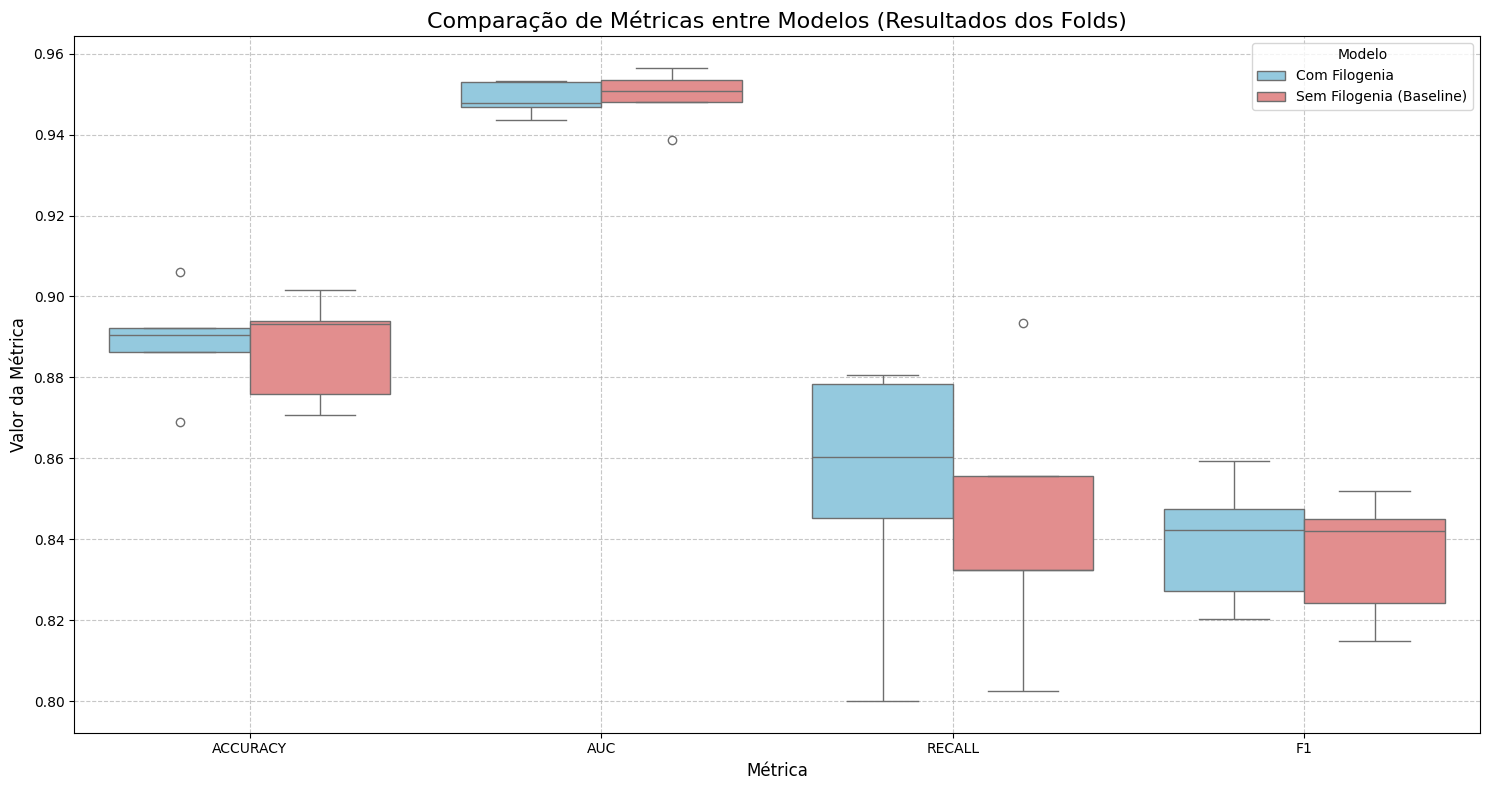


--- Gerando Curvas ROC Comparativas ---


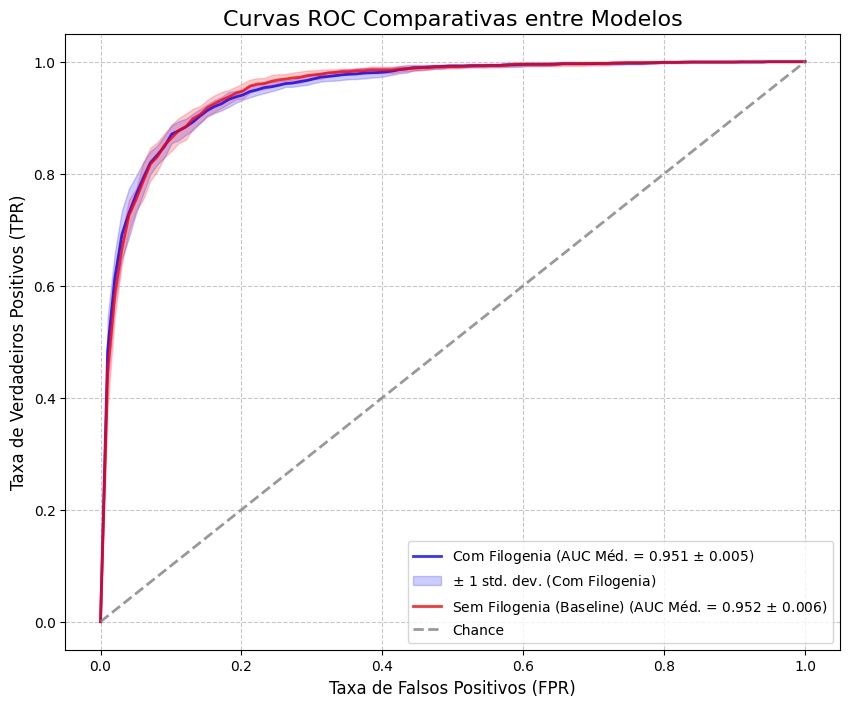


--- Gerando Gráfico Radar Comparativo ---


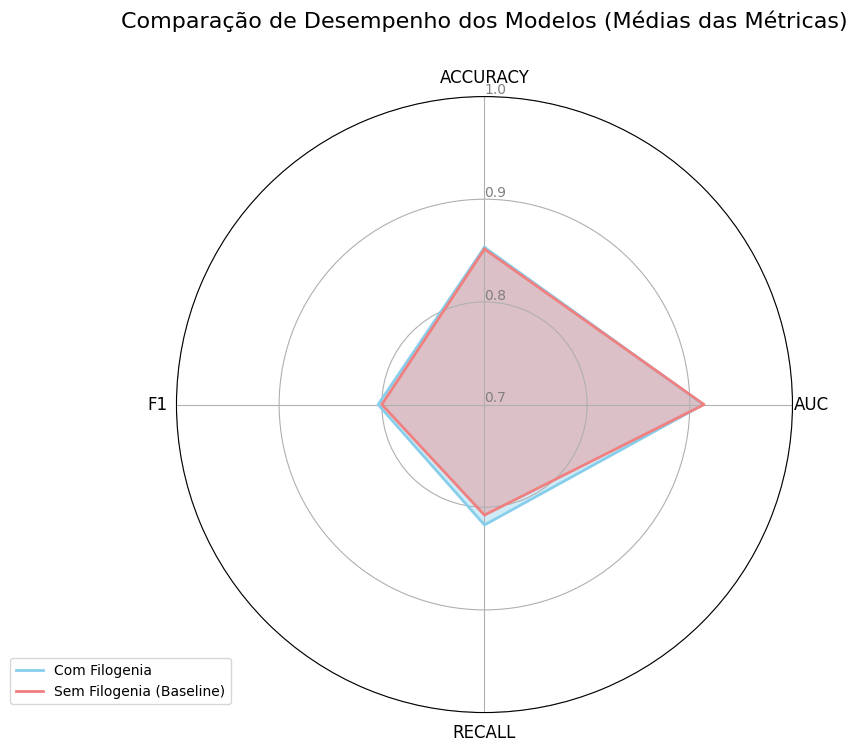

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc as sklearn_auc # Renomeado para evitar conflito com a métrica 'auc'
from math import pi

# --------------------------------------------------
# 1. BOXPLOTS COMPARATIVOS
# --------------------------------------------------
def plot_comparative_boxplots(results_filo, results_base, metrics=None):
    if metrics is None:
        metrics = ['accuracy', 'auc', 'recall', 'f1']

    data_plot = []
    for metric in metrics:
        for val in results_filo.get(metric, []):
            data_plot.append({'Modelo': 'Com Filogenia', 'Métrica': metric.upper(), 'Valor': val})
        for val in results_base.get(metric, []):
            data_plot.append({'Modelo': 'Sem Filogenia (Baseline)', 'Métrica': metric.upper(), 'Valor': val})

    df_plot = pd.DataFrame(data_plot)

    if df_plot.empty:
        print("Não há dados para gerar os boxplots. Verifique os resultados dos modelos.")
        return

    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Métrica', y='Valor', hue='Modelo', data=df_plot, palette={'Com Filogenia': 'skyblue', 'Sem Filogenia (Baseline)': 'lightcoral'})
    plt.title('Comparação de Métricas entre Modelos (Resultados dos Folds)', fontsize=16)
    plt.ylabel('Valor da Métrica', fontsize=12)
    plt.xlabel('Métrica', fontsize=12)
    plt.legend(title='Modelo')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("\n--- Gerando Boxplots Comparativos ---")
plot_comparative_boxplots(results_filo, results_base)

# --------------------------------------------------
# 2. CURVAS ROC
# --------------------------------------------------
def plot_roc_curves_comparison(results_filo, results_base, model_names):
    plt.figure(figsize=(10, 8))

    colors = ['blue', 'red']
    model_results_list = [results_filo, results_base]

    for i, model_results in enumerate(model_results_list):
        if 'roc_data' not in model_results or not model_results['roc_data']:
            print(f"Dados para curva ROC não encontrados para {model_names[i]}. Pulando.")
            continue

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        fold_roc_data = model_results['roc_data']

        for fold_idx, (y_true, y_pred_proba) in enumerate(fold_roc_data):
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            roc_auc = sklearn_auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            # Plotar ROC de cada fold (opcional, pode poluir o gráfico)
            # plt.plot(fpr, tpr, alpha=0.3, lw=1, label=f'{model_names[i]} Fold {fold_idx+1} (AUC = {roc_auc:.2f})')


        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = sklearn_auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        plt.plot(mean_fpr, mean_tpr, color=colors[i],
                 label=f'{model_names[i]} (AUC Méd. = {mean_auc:.3f} $\\pm$ {std_auc:.3f})',
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=.2,
                         label=f'$\\pm$ 1 std. dev. ({model_names[i]})' if i==0 else None) # Label apenas para o primeiro para evitar duplicatas

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
    plt.title('Curvas ROC Comparativas entre Modelos', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

print("\n--- Gerando Curvas ROC Comparativas ---")
# Certifique-se que 'roc_data' foi coletado corretamente em results_filo e results_base
if 'roc_data' in results_filo and 'roc_data' in results_base:
    plot_roc_curves_comparison(results_filo, results_base, ['Com Filogenia', 'Sem Filogenia (Baseline)'])
else:
    print("Dados para curva ROC não foram completamente coletados. Verifique a modificação das funções 'main'.")


# --------------------------------------------------
# 3. GRÁFICOS RADAR (SPIDER CHART)
# --------------------------------------------------
def plot_radar_chart(results_filo, results_base, metrics=None):
    if metrics is None:
        metrics = ['accuracy', 'auc', 'recall', 'f1']

    labels = [m.upper() for m in metrics]
    num_vars = len(labels)

    # Calcular médias das métricas
    stats_filo = [np.mean(results_filo.get(m, [0])) for m in metrics]
    stats_base = [np.mean(results_base.get(m, [0])) for m in metrics]

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    stats_filo += stats_filo[:1] # Fechar o círculo
    stats_base += stats_base[:1] # Fechar o círculo
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Modelo com Filogenia
    ax.plot(angles, stats_filo, linewidth=2, linestyle='solid', label='Com Filogenia', color='skyblue')
    ax.fill(angles, stats_filo, 'skyblue', alpha=0.4)

    # Modelo Sem Filogenia (Baseline)
    ax.plot(angles, stats_base, linewidth=2, linestyle='solid', label='Sem Filogenia (Baseline)', color='lightcoral')
    ax.fill(angles, stats_base, 'lightcoral', alpha=0.4)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)

    # Definir limites do eixo y (radial) para melhor visualização, e.g., de 0.5 a 1.0
    # Se todas as suas métricas estiverem, por exemplo, acima de 0.7, pode ajustar:
    min_val_all_metrics = min(min(stats_filo[:-1]), min(stats_base[:-1]))
    # Ajustar o limite inferior para um pouco abaixo do mínimo ou um valor razoável.
    lower_y_limit = max(0, min_val_all_metrics - 0.1) if min_val_all_metrics > 0.1 else 0
    ax.set_ylim(lower_y_limit, 1.0) # Assumindo que métricas são no máximo 1.0

    plt.yticks(np.arange(lower_y_limit, 1.05, 0.1), [f"{val:.1f}" for val in np.arange(lower_y_limit, 1.05, 0.1)], color="grey", size=10)

    plt.title('Comparação de Desempenho dos Modelos (Médias das Métricas)', size=16, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.grid(True)
    plt.show()

print("\n--- Gerando Gráfico Radar Comparativo ---")
plot_radar_chart(results_filo, results_base)

# **GRAFO FILOGENÉTICO - TAG**

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random # Para escolher nós aleatórios, se necessário
from matplotlib.lines import Line2D # Importar Line2D para legendas

def visualize_tag_graph_with_labels(
    G_original,
    G_labels_original,
    title="Grafo TAG",
    title_override=None,
    node_in_degrees=None,
    leaf_nodes_to_highlight=None,
    central_node_ego=None,
    layout_type='spring',
    node_size_base=100,
    node_size_multiplier=100,
    font_size=8,
    with_node_ids=False,
    legend=True,
    figsize=(18,18),
    dpi=100
):
    if G_original is None or not G_original.nodes():
        print(f"No graph to display for {title if title_override is None else title_override}.")
        return

    nodes_with_edges = [node for node in G_original.nodes() if G_original.in_degree(node) > 0 or G_original.out_degree(node) > 0]
    if not nodes_with_edges:
        print(f"No nodes with edges to display for {title if title_override is None else title_override}.")
        return
    G_filtered = G_original.subgraph(nodes_with_edges).copy()

    if not G_filtered.nodes():
         print(f"After filtering isolated nodes, no nodes remain for {title if title_override is None else title_override}.")
         return

    G_labels_filtered = {node: G_labels_original.get(node, str(node)) for node in G_filtered.nodes()}

    plt.figure(figsize=figsize, dpi=dpi)

    # Layout (mesma lógica de antes)
    if layout_type == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_filtered)
    elif layout_type == 'spectral':
        pos = nx.spectral_layout(G_filtered)
    elif layout_type == 'dot' and nx.nx_agraph.is_available():
        try:
            pos = nx.nx_agraph.graphviz_layout(G_filtered, prog="dot")
        except:
            print("Graphviz 'dot' layout falhou, usando 'spring' como fallback.")
            pos = nx.spring_layout(G_filtered, k=0.25, iterations=40, seed=42)
    else: # spring como padrão ou fallback
        pos = nx.spring_layout(G_filtered, k=0.25, iterations=40, seed=42)


    # --- ALTERAÇÃO AQUI ---
    # Cores dos Nós (CORRIGIDO: 1 para Fake/Rumor, 0 para Verdadeiro/Non-Rumor)
    node_colors = []
    rumor_nodes = [] # Para possível uso na legenda
    non_rumor_nodes = [] # Para possível uso na legenda

    for node in G_filtered.nodes():
        label_value = G_labels_filtered.get(node)
        if label_value == 1: # Rumor/Fake (CORRIGIDO)
            node_colors.append('salmon') # Cor para fake news
            rumor_nodes.append(node)
        elif label_value == 0: # Não Rumor/Real (CORRIGIDO)
            node_colors.append('skyblue') # Cor para notícias verdadeiras
            non_rumor_nodes.append(node)
        else:
            node_colors.append('lightgrey') # Cor para labels desconhecidos

    # Tamanho dos Nós (mesma lógica de antes)
    node_sizes = [node_size_base] * G_filtered.number_of_nodes()
    if node_in_degrees:
        node_sizes = [
            node_size_base + node_in_degrees.get(node, 0) * node_size_multiplier
            for node in G_filtered.nodes()
        ]

    # Destaque para Nós Folha e Nó Central (mesma lógica de antes)
    node_edge_colors = ['black'] * G_filtered.number_of_nodes()
    node_line_widths = [1] * G_filtered.number_of_nodes()
    node_shapes = ['o'] * G_filtered.number_of_nodes()

    if leaf_nodes_to_highlight:
        for i, node in enumerate(G_filtered.nodes()):
            if node in leaf_nodes_to_highlight:
                node_shapes[i] = 's'
                node_edge_colors[i] = 'green'
                node_line_widths[i] = 2

    if central_node_ego and central_node_ego in G_filtered:
         for i, node in enumerate(G_filtered.nodes()):
            if node == central_node_ego:
                node_edge_colors[i] = 'purple'
                node_line_widths[i] = 3
                node_shapes[i] = 'D'

    nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_colors,
                           edgecolors=node_edge_colors, linewidths=node_line_widths, alpha=0.8)

    nx.draw_networkx_edges(G_filtered, pos, alpha=0.3, width=0.6, arrows=True, arrowstyle='->', arrowsize=10, edge_color='gray')

    if with_node_ids:
        labels_to_draw_ids = {node: str(node) for node in G_filtered.nodes()}
        nx.draw_networkx_labels(G_filtered, pos, labels=labels_to_draw_ids, font_size=font_size, alpha=0.85)

    final_title = title_override if title_override is not None else title
    plt.title(final_title, size=16)

    if legend:
        # --- ALTERAÇÃO AQUI ---
        # Criar handles para a legenda manualmente (CORRIGIDO)
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Rumor/Fake (1)', markerfacecolor='salmon', markersize=10, markeredgecolor='black'),
            Line2D([0], [0], marker='o', color='w', label='Não Rumor/Real (0)', markerfacecolor='skyblue', markersize=10, markeredgecolor='black')
        ]
        # Lógica para adicionar outros elementos da legenda (mesma de antes)
        if leaf_nodes_to_highlight:
             legend_elements.append(Line2D([0], [0], marker='s', color='w', label='Nó Folha', markerfacecolor='lightgrey', markersize=10, markeredgecolor='green', linewidth=2))
        if central_node_ego:
            legend_elements.append(Line2D([0], [0], marker='D', color='w', label='Nó Central (ego)', markerfacecolor='lightgrey', markersize=10, markeredgecolor='purple', linewidth=2))
        if node_in_degrees:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Tamanho ~ Grau de Entrada', markerfacecolor='grey', markersize=5, alpha=0.0))

        ax = plt.gca()
        ax.legend(handles=legend_elements, loc='best', fontsize='small')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

Grafo completo capturado: 5802 nós, 12979 arestas.


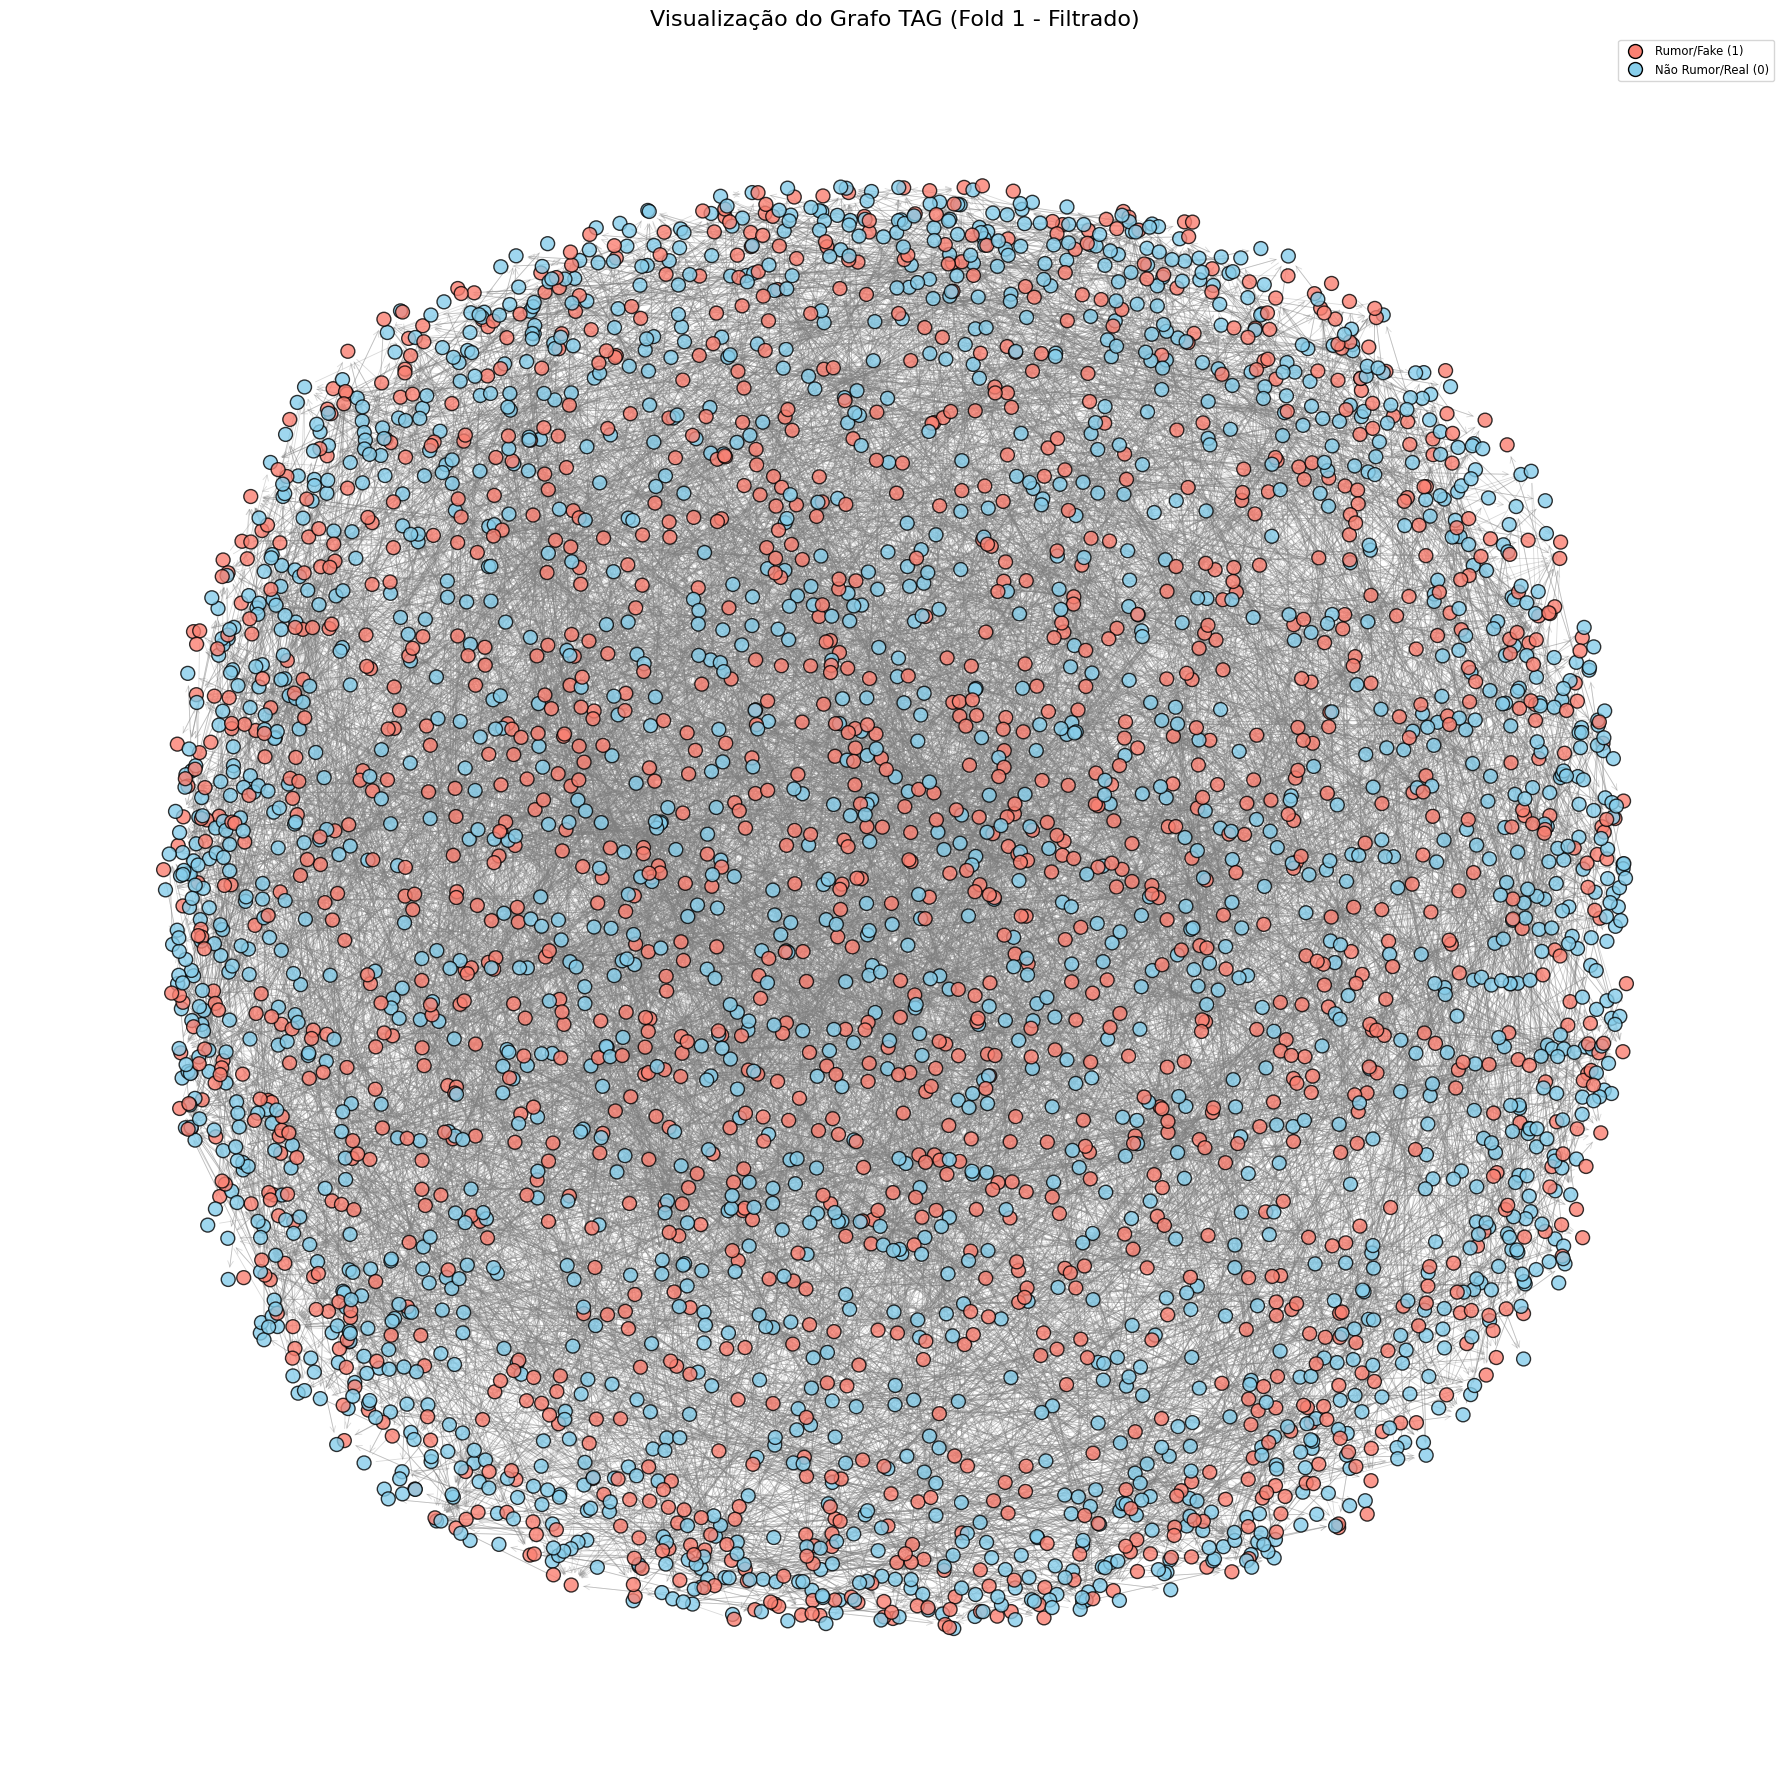

In [20]:
# Visualização do Grafo Filogenético

# Primeiro, verifique se as variáveis globais foram definidas
if 'G_captured_for_visualization_global' in globals() and G_captured_for_visualization_global is not None:
    print(f"Grafo completo capturado: {G_captured_for_visualization_global.number_of_nodes()} nós, {G_captured_for_visualization_global.number_of_edges()} arestas.")

    current_labels_for_vis = G_labels_for_visualization_global if 'G_labels_for_visualization_global' in globals() and G_labels_for_visualization_global is not None else {}

    if not G_captured_for_visualization_global.nodes():
         print("ALERTA: O grafo capturado não tem nós! Não será possível visualizar.")
    else:
        # A função visualize_tag_graph_with_labels já lida com grafos sem arestas ou com apenas nós isolados.
        # Chame-a diretamente se o grafo e os nós existem.
        visualize_tag_graph_with_labels(
            G_captured_for_visualization_global,
            current_labels_for_vis,
            with_node_ids=False, # Mostrar IDs para identificar
            title="Visualização do Grafo TAG (Fold 1 - Filtrado)" # Ajuste o título conforme preferir
        )
else:
    print("Nenhum grafo G_captured_for_visualization_global foi capturado para visualização.")

# Opcional: Verificação adicional para os labels
if 'G_labels_for_visualization_global' not in globals() or G_labels_for_visualization_global is None:
    print("ALERTA: Labels G_labels_for_visualization_global não foram capturados.")
elif not G_labels_for_visualization_global:
    print("ALERTA: O dicionário de labels G_labels_for_visualization_global está vazio!")

In [11]:
# -------------------------
# ------- EGO GRAPH -------
# -------------------------

def plot_ego_graph_for_hypothesis(
    full_graph,
    central_node_id,
    node_labels_dict, # Dicionário global de labels {node_id: label}
    radius=1,
    title_prefix="",
    **vis_kwargs
):
    if central_node_id not in full_graph:
        print(f"Erro: Nó {central_node_id} não encontrado no grafo completo.")
        return

    print(f"\nAnalisando ego graph para o nó central: {central_node_id}")
    central_node_label_val = node_labels_dict.get(central_node_id, "Desconhecido")

    # --- ALTERAÇÃO AQUI ---
    label_str = "Rumor/Fake (1)" if central_node_label_val == 1 else "Não Rumor/Real (0)" if central_node_label_val == 0 else "Desconhecido" # CORRIGIDO

    print(f"  Label do nó central: {label_str}")
    print(f"  No grafo completo: In-degree={full_graph.in_degree(central_node_id)}, Out-degree={full_graph.out_degree(central_node_id)}\n")

    ego_subgraph = nx.ego_graph(full_graph, central_node_id, radius=radius, undirected=False)

    if not ego_subgraph.nodes():
        print(f"  ERRO: Nenhum nó no ego_subgraph para o nó {central_node_id}. Verifique a lógica.")
        return

    subgraph_labels = {node: node_labels_dict.get(node) for node in ego_subgraph.nodes() if node in node_labels_dict}
    subgraph_in_degrees = {node: ego_subgraph.in_degree(node) for node in ego_subgraph.nodes()}
    subgraph_leaf_nodes = [node for node, out_deg in ego_subgraph.out_degree() if out_deg == 0]

    title = f"{title_prefix}Ego Graph: Nó {central_node_id} (Label: {label_str}, Raio: {radius})"
    print(f"  Plotando ego graph: {ego_subgraph.number_of_nodes()} nós, {ego_subgraph.number_of_edges()} arestas.")

    visualize_tag_graph_with_labels(
        ego_subgraph,
        subgraph_labels,
        title_override=title,
        node_in_degrees=subgraph_in_degrees,
        leaf_nodes_to_highlight=subgraph_leaf_nodes,
        central_node_ego=central_node_id,
        layout_type='kamada_kawai',
        with_node_ids=True,
        **vis_kwargs
    )

--- Visualizando Hipótese 2.1 (Fake News como Folha) ---

Analisando ego graph para o nó central: 262
  Label do nó central: Rumor/Fake (1)
  No grafo completo: In-degree=0, Out-degree=0

  Plotando ego graph: 1 nós, 0 arestas.
No nodes with edges to display for H2.1: Ego Graph: Nó 262 (Label: Rumor/Fake (1), Raio: 1).

--- Visualizando Hipótese 2.2 (Recombinação em Fake News) ---

Analisando ego graph para o nó central: 4638
  Label do nó central: Rumor/Fake (1)
  No grafo completo: In-degree=35, Out-degree=5

  Plotando ego graph: 6 nós, 18 arestas.


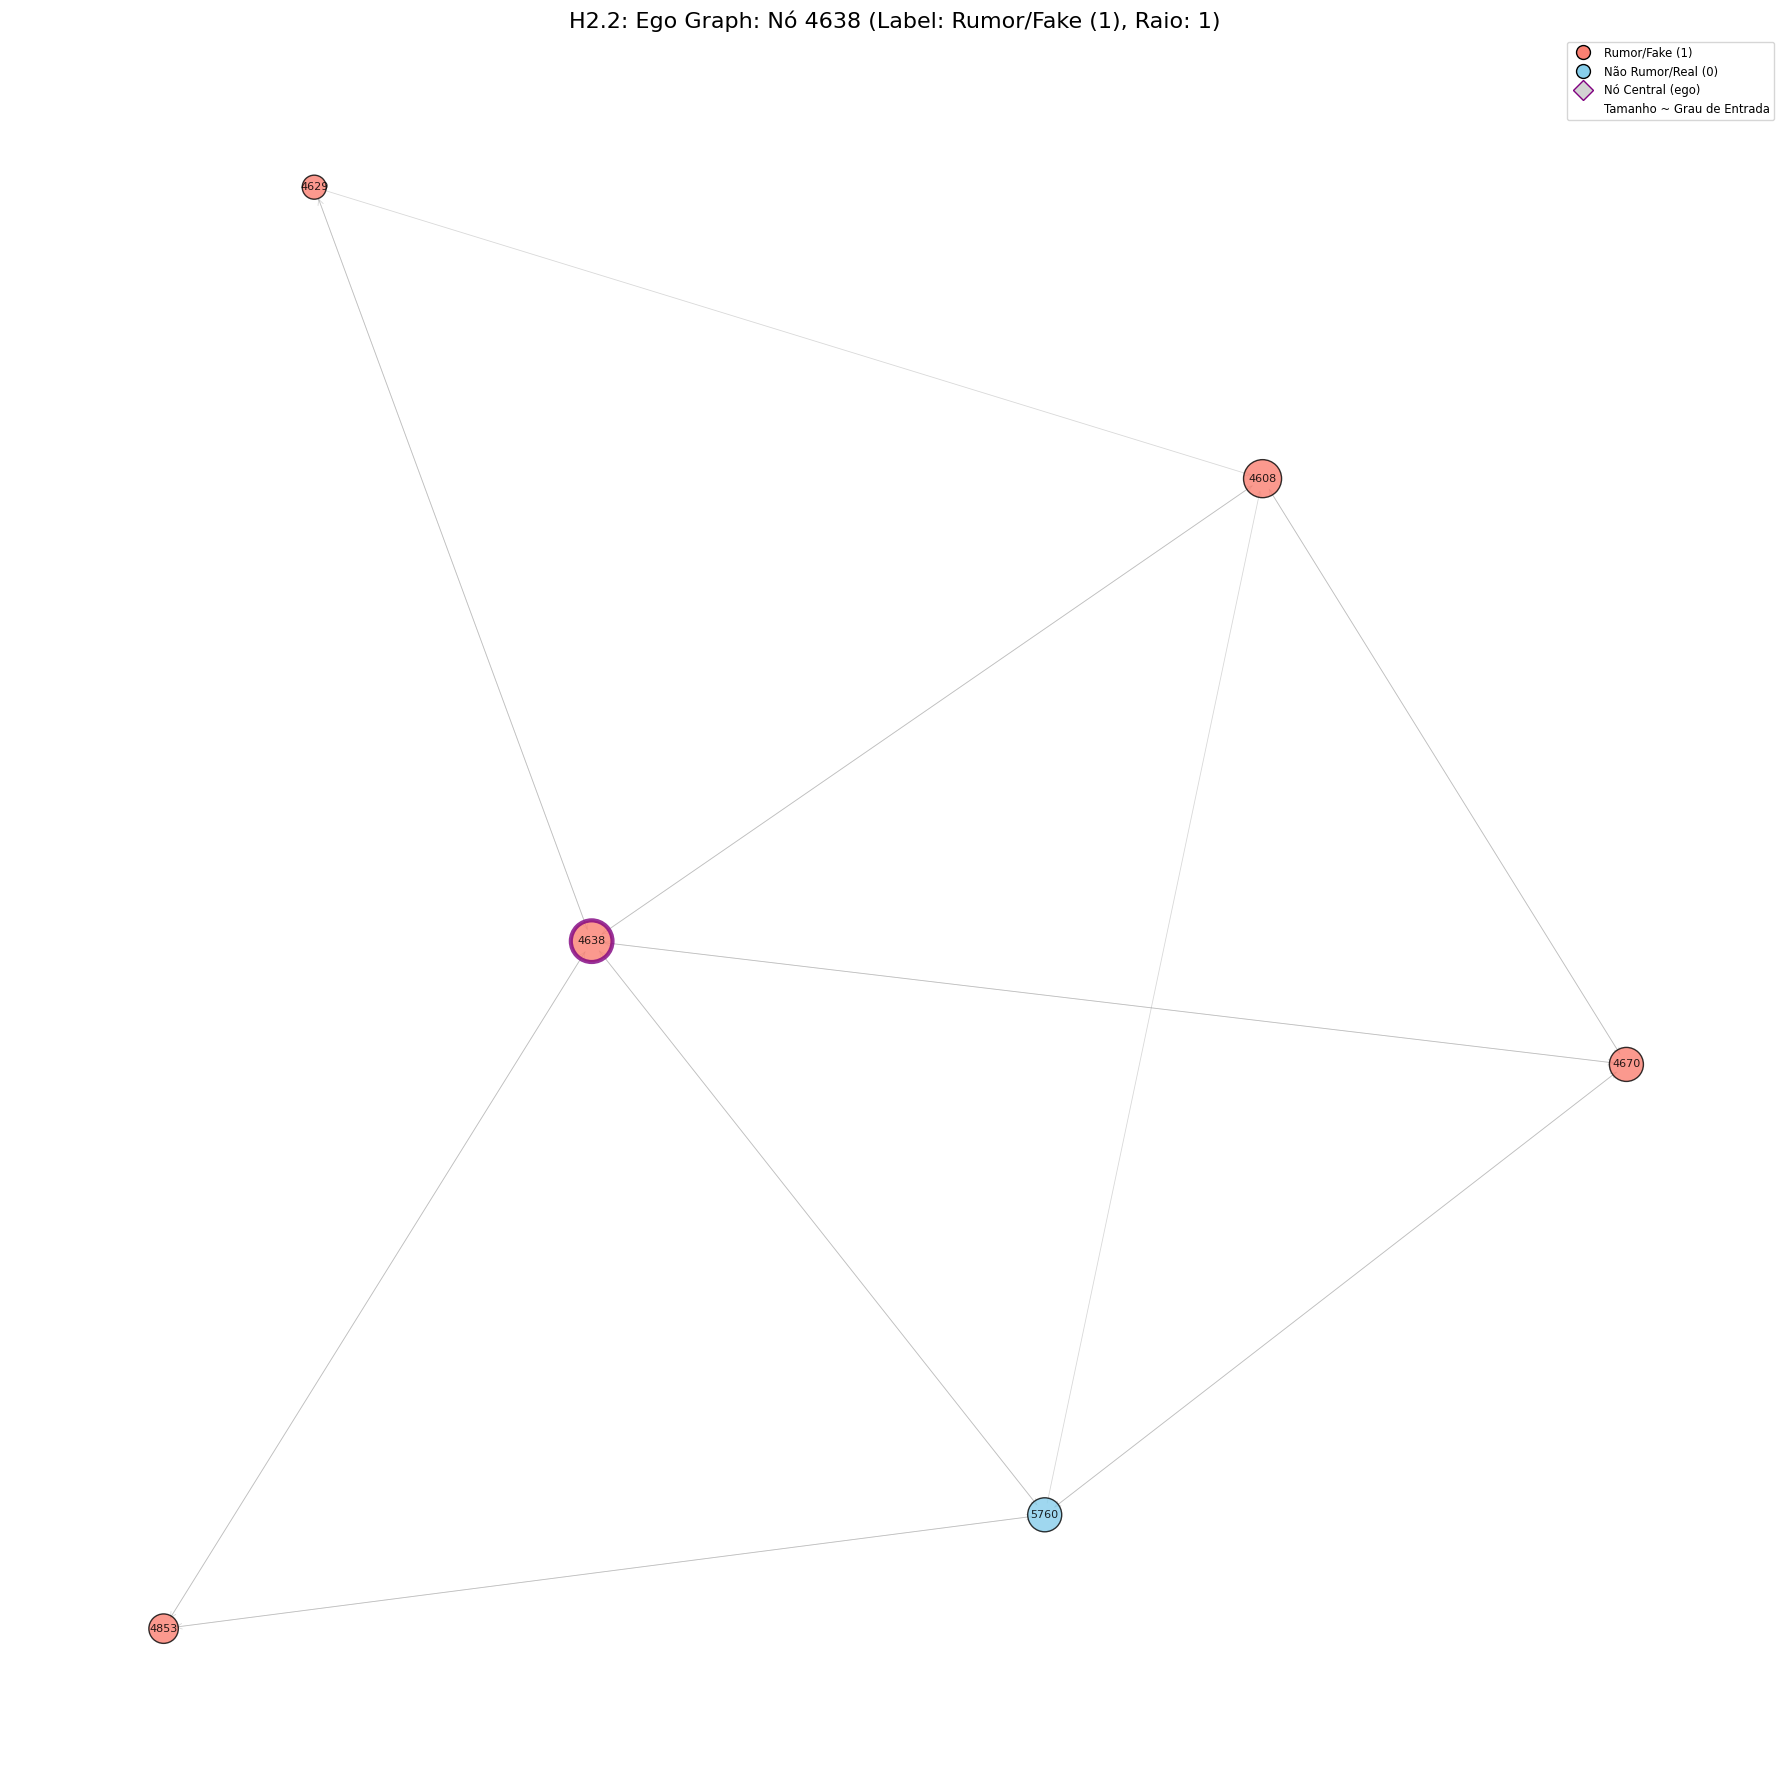


--- Visualizando Comparativo (Notícia Verdadeira) ---

Analisando ego graph para o nó central: 1821
  Label do nó central: Não Rumor/Real (0)
  No grafo completo: In-degree=31, Out-degree=5

  Plotando ego graph: 6 nós, 23 arestas.


In [12]:
# -------------------------------------------------------------------------------------------------------------------
# ------------------------ Gerar Visualização de um EGO GRAPH de uma sub-arvore para Análise ------------------------
# -------------------------------------------------------------------------------------------------------------------
G_full = None
G_labels_full = {}

if 'G_captured_for_visualization_global' in globals() and G_captured_for_visualization_global is not None:
    G_full = G_captured_for_visualization_global
    if 'G_labels_for_visualization_global' in globals() and G_labels_for_visualization_global is not None:
        G_labels_full = G_labels_for_visualization_global
    else:
        print("ALERTA: Labels G_labels_for_visualization_global não foram capturados. Usando dicionário vazio.")
else:
    print("ALERTA: Grafo G_captured_for_visualization_global não foi capturado. Não é possível gerar ego graphs.")

if G_full:
    # --- ALTERAÇÃO AQUI ---
    # --- Exemplo para Hipótese 2.1 (Fake news como folhas) ---
    fake_news_nodes_global = [node for node, label in G_labels_full.items() if label == 1 and node in G_full] # CORRIGIDO: label 1 é fake
    leaf_fake_news_global = [node for node in fake_news_nodes_global if G_full.out_degree(node) == 0]

    if leaf_fake_news_global:
        node_fn_leaf_candidate = None
        for node_fnl in leaf_fake_news_global:
            if G_full.in_degree(node_fnl) > 0:
                 node_fn_leaf_candidate = node_fnl
                 break
        if node_fn_leaf_candidate is None and leaf_fake_news_global:
             node_fn_leaf_candidate = random.choice(leaf_fake_news_global)

        if node_fn_leaf_candidate:
            print(f"--- Visualizando Hipótese 2.1 (Fake News como Folha) ---")
            plot_ego_graph_for_hypothesis(
                G_full,
                node_fn_leaf_candidate,
                G_labels_full,
                radius=1,
                title_prefix="H2.1: ",
                node_size_base=150, node_size_multiplier=150 # Ajuste se necessário
            )
        else:
            print("Nenhuma fake news folha com vizinhança encontrada para exemplo H2.1.")
    else:
        print("Nenhuma fake news que seja nó folha encontrada no grafo global para exemplo H2.1.")

    # --- ALTERAÇÃO AQUI ---
    # --- Exemplo para Hipótese 2.2 (Alta recombinação em Fake News) ---
    if fake_news_nodes_global:
        fake_news_in_degrees_global = {node: G_full.in_degree(node) for node in fake_news_nodes_global}
        if fake_news_in_degrees_global:
            node_fn_recomb_candidate = None
            sorted_fn_by_indegree = sorted(fake_news_in_degrees_global.items(), key=lambda item: item[1], reverse=True)

            for node, indeg in sorted_fn_by_indegree:
                if indeg > 1 :
                    node_fn_recomb_candidate = node
                    break

            if node_fn_recomb_candidate:
                print(f"\n--- Visualizando Hipótese 2.2 (Recombinação em Fake News) ---")
                plot_ego_graph_for_hypothesis(
                    G_full,
                    node_fn_recomb_candidate,
                    G_labels_full,
                    radius=1,
                    title_prefix="H2.2: ",
                    node_size_base=150, node_size_multiplier=150
                )
            else:
                print("Nenhuma fake news com in-degree > 1 encontrada para exemplo H2.2.")
        else:
            print("Nenhuma fake news com informação de in-degree encontrada para exemplo H2.2.")

    # --- ALTERAÇÃO AQUI ---
    # --- Exemplo Comparativo: Nó de Notícia Verdadeira com estrutura similar/contrastante ---
    true_news_nodes_global = [node for node, label in G_labels_full.items() if label == 0 and node in G_full] # CORRIGIDO: label 0 é real
    if true_news_nodes_global:
        node_tn_candidate = None
        true_news_in_degrees_global = {node: G_full.in_degree(node) for node in true_news_nodes_global}
        if true_news_in_degrees_global:
             for node, indeg in sorted(true_news_in_degrees_global.items(), key=lambda item: item[1], reverse=True):
                if indeg > 0:
                    node_tn_candidate = node
                    break

        if node_tn_candidate is None and true_news_nodes_global:
            node_tn_candidate = random.choice(true_news_nodes_global)

        if node_tn_candidate:
            print(f"\n--- Visualizando Comparativo (Notícia Verdadeira) ---")
            plot_ego_graph_for_hypothesis(
                G_full,
                node_tn_candidate,
                G_labels_full,
                radius=1,
                title_prefix="Comparativo: ",
                node_size_base=150, node_size_multiplier=150
            )
        else:
            print("Nenhum nó de notícia verdadeira encontrado para exemplo comparativo.")

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D # Para a legenda

def visualize_full_with_highlighted_subgraphs(
    full_graph,
    full_labels,
    subgraphs_to_highlight_data, # Lista de tuplas: [(subgraph1, central_node1), (subgraph2, central_node2), ...]
    title="Grafo Completo com Subgrafos em Destaque",
    layout_type='kamada_kawai', # 'kamada_kawai' pode ser melhor para grafos grandes que 'spring'
    dimmed_node_size=10,
    dimmed_node_color='lightgray',
    dimmed_node_alpha=0.3,
    dimmed_edge_width=0.1,
    dimmed_edge_color='lightgray',
    dimmed_edge_alpha=0.2,
    highlighted_node_size_base=100, # Mesmo base da função de ego graph
    highlighted_node_size_multiplier=100, # Mesmo multiplicador
    highlighted_edge_width=1.0,
    highlighted_edge_alpha=0.9,
    font_size=7,
    with_node_ids_highlighted=False, # Mostrar IDs apenas para nós destacados
    figsize=(25, 25), # Pode precisar de um tamanho grande
    dpi=100,
    k_spring=None, # Parâmetro k para spring_layout, se usado
    iterations_spring=50 # Iterações para spring_layout
):
    if full_graph is None or not full_graph.nodes():
        print("Grafo completo não fornecido ou vazio.")
        return

    plt.figure(figsize=figsize, dpi=dpi)

    # 1. Calcular layout para o grafo COMPLETO
    print("Calculando layout para o grafo completo (pode levar um tempo)...")
    if layout_type == 'spring':
        pos = nx.spring_layout(full_graph, k=k_spring, iterations=iterations_spring, seed=42)
    elif layout_type == 'kamada_kawai':
        # Kamada-Kawai pode ser muito lento para grafos > algumas centenas de nós.
        # Se for muito lento, considere um spring_layout com menos iterações ou um layout aleatório como fallback.
        try:
            pos = nx.kamada_kawai_layout(full_graph)
        except Exception as e:
            print(f"Kamada-Kawai falhou ({e}), usando spring_layout como fallback.")
            pos = nx.spring_layout(full_graph, k=k_spring, iterations=max(10, iterations_spring // 2), seed=42) # Menos iterações
    elif layout_type == 'dot' and nx.nx_agraph.is_available():
        try:
            pos = nx.nx_agraph.graphviz_layout(full_graph, prog="dot")
        except:
            print("Graphviz 'dot' layout falhou, usando 'spring' como fallback.")
            pos = nx.spring_layout(full_graph, k=k_spring, iterations=iterations_spring, seed=42)
    else: # Aleatório como último recurso se tudo mais falhar ou for muito lento
        print(f"Layout '{layout_type}' não suportado ou falhou, usando layout aleatório.")
        pos = nx.random_layout(full_graph, seed=42)
    print("Layout calculado.")

    # 2. Desenhar todos os nós e arestas do grafo completo de forma esmaecida
    print("Desenhando grafo completo esmaecido...")
    nx.draw_networkx_edges(
        full_graph, pos,
        width=dimmed_edge_width,
        edge_color=dimmed_edge_color,
        alpha=dimmed_edge_alpha,
        arrows=False # Não mostrar setas para o fundo para reduzir poluição
    )
    nx.draw_networkx_nodes(
        full_graph, pos,
        node_size=dimmed_node_size,
        node_color=dimmed_node_color,
        alpha=dimmed_node_alpha,
        linewidths=0 # Sem bordas para nós esmaecidos
    )
    print("Grafo esmaecido desenhado.")

    # 3. Coletar todos os nós e arestas dos subgrafos a serem destacados
    all_highlighted_nodes = set()
    all_highlighted_edges = set()
    for sg_data in subgraphs_to_highlight_data:
        sg = sg_data[0] # O objeto subgraph
        all_highlighted_nodes.update(sg.nodes())
        all_highlighted_edges.update(sg.edges())

    # Converter para lista para o nodelist/edgelist do NetworkX
    nodelist_highlight = list(all_highlighted_nodes)
    edgelist_highlight = list(all_highlighted_edges)

    # 4. Preparar estilos para os nós destacados (cores, tamanhos, formas)
    # Usar cores e tamanhos baseados nas propriedades GLOBAIS dos nós
    highlight_node_colors = []
    highlight_node_sizes = []
    highlight_node_edge_colors = ['black'] * len(nodelist_highlight)
    highlight_node_line_widths = [1] * len(nodelist_highlight)
    # highlight_node_shapes = ['o'] * len(nodelist_highlight) # Ainda complexo com NetworkX

    # Determinar folhas GLOBAIS para possível destaque diferente (se desejado)
    # global_leaf_nodes = {node for node, out_deg in full_graph.out_degree() if out_deg == 0}

    for i, node in enumerate(nodelist_highlight):
        label_value = full_labels.get(node)
        if label_value == 1: # Rumor/Fake
            highlight_node_colors.append('lightsalmon') # Cor mais forte para fake destacado
        elif label_value == 0: # Não Rumor/Real
            highlight_node_colors.append('dodgerblue') # Cor mais forte para real destacado
        else:
            highlight_node_colors.append('darkgrey')

        # Tamanho baseado no in-degree GLOBAL
        in_degree_global = full_graph.in_degree(node) if full_graph.has_node(node) else 0
        highlight_node_sizes.append(highlighted_node_size_base + in_degree_global * highlighted_node_size_multiplier)

        # Destaque para os nós centrais dos ego graphs
        for sg_data_inner in subgraphs_to_highlight_data:
            central_node_of_sg = sg_data_inner[1]
            if node == central_node_of_sg:
                highlight_node_edge_colors[i] = 'fuchsia' # Borda bem destacada para os centrais
                highlight_node_line_widths[i] = 2.5
                break # Um nó só pode ser central uma vez na lista (ou o último destaque prevalece)

    # 5. Redesenhar os nós e arestas destacados por cima
    print(f"Desenhando {len(nodelist_highlight)} nós e {len(edgelist_highlight)} arestas em destaque...")
    if nodelist_highlight:
        nx.draw_networkx_nodes(
            full_graph, pos,
            nodelist=nodelist_highlight,
            node_color=highlight_node_colors,
            node_size=highlight_node_sizes,
            edgecolors=highlight_node_edge_colors,
            linewidths=highlight_node_line_widths,
            alpha=0.4 # Mais opaco
        )

    if edgelist_highlight:
        nx.draw_networkx_edges(
            full_graph, pos,
            edgelist=edgelist_highlight,
            width=highlighted_edge_width,
            edge_color='black', # Arestas destacadas em preto
            alpha=highlighted_edge_alpha,
            arrows=True,
            arrowstyle='->',
            arrowsize=10
        )

    if with_node_ids_highlighted and nodelist_highlight:
        labels_to_draw_ids = {node: str(node) for node in nodelist_highlight}
        nx.draw_networkx_labels(full_graph, pos, labels=labels_to_draw_ids, font_size=font_size,
                                font_color='black', bbox=dict(facecolor='white', alpha=0.5, pad=0))


    print("Destaques desenhados.")
    plt.title(title, size=20)

    # Legenda
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Rumor/Fake (1) - Destaque', markerfacecolor='lightsalmon', markersize=10, alpha=0.5),
        Line2D([0], [0], marker='o', color='w', label='Não Rumor/Real (0) - Destaque', markerfacecolor='dodgerblue', markersize=10, alpha=0.5),
        Line2D([0], [0], marker='o', color='w', label='Nó Central de Ego (borda fúcsia)', markerfacecolor='lightgrey', markersize=10, markeredgecolor='fuchsia', mew=2.5),
        Line2D([0], [0], marker='o', color='w', label='Outros Nós (fundo)', markerfacecolor=dimmed_node_color, markersize=5, alpha=dimmed_node_alpha),
        Line2D([0], [0], color=dimmed_edge_color, lw=2, label='Outras Arestas (fundo)', alpha=dimmed_edge_alpha),
        Line2D([0], [0], color='black', lw=2, label='Arestas em Destaque')
    ]
    ax = plt.gca()
    ax.legend(handles=legend_elements, loc='best', fontsize='medium')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [29]:
# Gerar camadad e Ego Graphs

if G_full:
    # Lista para armazenar os dados dos subgrafos a destacar
    subgraphs_data_to_highlight = []
    radius_ego = 1 # Raio para os ego graphs

    central_nodes_for_highlight = []
    if 'node_fn_leaf_candidate' in globals() and node_fn_leaf_candidate:
         central_nodes_for_highlight.append(node_fn_leaf_candidate)
    if 'node_fn_recomb_candidate' in globals() and node_fn_recomb_candidate:
         central_nodes_for_highlight.append(node_fn_recomb_candidate)
    if 'node_tn_candidate' in globals() and node_tn_candidate: # Nó de comparação
         central_nodes_for_highlight.append(node_tn_candidate)

    # Removendo duplicatas e garantindo que existem no grafo
    central_nodes_for_highlight = list(set(node_id for node_id in central_nodes_for_highlight if G_full.has_node(node_id)))

    if not central_nodes_for_highlight:
        print("Nenhum nó central válido selecionado para destaque. Verifique os candidatos.")
    else:
        print(f"Nós centrais selecionados para destaque no grafo completo: {central_nodes_for_highlight}")
        for central_node in central_nodes_for_highlight:
            ego_sg = nx.ego_graph(G_full, central_node, radius=radius_ego, undirected=False)
            if ego_sg.nodes():
                subgraphs_data_to_highlight.append((ego_sg, central_node))
            else:
                print(f"Atenção: Ego graph para {central_node} resultou vazio.")

        if subgraphs_data_to_highlight:
            # Chamar a nova função de visualização
            # Ajuste k_spring se for usar spring_layout; pode ser None para que NetworkX escolha.
            # Para grafos grandes, kamada_kawai pode ser melhor mas mais lento.
            # Se o seu grafo G_full é muito denso, spring_layout com k maior pode ajudar a espalhar.
            # Ex: k_spring_val = 0.1 / np.sqrt(G_full.number_of_nodes()) # Uma heurística
            k_spring_val = 0.05 # Teste valores; None para padrão. Para 5800 nós, o padrão pode ser ok.

            visualize_full_with_highlighted_subgraphs(
                G_full,
                G_labels_full,
                subgraphs_data_to_highlight,
                title="Visualização Global com Ego Graphs em Destaque",
                layout_type='spring', # 'kamada_kawai' pode ser melhor para grafos grandes que 'spring'
                dimmed_node_size=10,
                dimmed_node_color='lightgray',
                dimmed_node_alpha=0.0,
                dimmed_edge_width=0.0,
                dimmed_edge_color='lightgray',
                dimmed_edge_alpha=0.0,
                k_spring=k_spring_val,
                iterations_spring=30, # Reduza para acelerar, aumente para melhor layout (se spring)
                highlighted_node_size_base=80,
                highlighted_node_size_multiplier=80,
                highlighted_edge_width=1.2,
                with_node_ids_highlighted=False, # Mostrar IDs pode poluir muito
                figsize=(30,30), # Aumente bem o tamanho da figura
                dpi=75 # Reduzir DPI pode ajudar com o tempo de renderização se a figura for muito grande
            )
        else:
            print("Nenhum ego graph válido foi gerado para destaque.")

else:
    print("Grafo G_full não está disponível para visualização.")

Nós centrais selecionados para destaque no grafo completo: [1821, 262, 4638]
Calculando layout para o grafo completo (pode levar um tempo)...
Layout calculado.
Desenhando grafo completo esmaecido...
Grafo esmaecido desenhado.
Desenhando 13 nós e 41 arestas em destaque...
Destaques desenhados.
